In [1]:
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.ndimage import interpolation
from statsmodels.stats.anova import AnovaRM
import time
import sys
import math
import pylab as py
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import scipy.stats as sci 
import seaborn as sns
import statannot
import json

# sns.set_style(style='whitegrid')

## Functions

In [2]:
def GetAng(a,b,c):
    ang = math.degrees(math.atan2(c[1] - b[1], c[0] - b[0]) - math.atan2(a[1] - b[1], a[0] - b[0]))
    return 360 - (ang + 360 if ang < 0 else ang)

In [3]:
def ResizeArray(data, newSize):
    x = data
    i = newSize

    lenX = len(x)

    if lenX == 0:
        lenX = 1
        z = i / lenX
    else:
        z = i / lenX
        x_int = interpolation.zoom(x,z)

    return x_int

In [4]:
def ReadFiles(path, files):
    # Define data frame variable
    df = None 
    startTime = time.time()
  
    print('Number of files: ', len(files))
    
    # Load each file into the data frame 
    for i in range(len(files)): 
    
        if ".json" in files[i] and "Phase" in files[i] and "QNumber" not in files[i]:    
        # if "txt.json" in files[i] and "Phase" in files[i]:
              # print(files[i])

            # elapsedTime = time.time() - startTime
            # print('Time passed: ', np.round(elapsedTime), '\t sec \r')

            # Extract file name info and add to the dataframe 
            fileWords = files[i].split("_")

            # Extract phase 
            idx = fileWords.index("Phase")
            phase = fileWords[idx + 1]

            # Extract user ID 
            idx = fileWords.index("trial")
            userID = fileWords[idx - 1]

            # Add trial number to data frame 
            try:
#                 print('Path and File: ', [path + '/' + files[i]])
                tmpDF = pd.read_json(path + '/' + files[i])
                tmpDF.insert(0, "Phase", phase, True)
                tmpDF.insert(0, "UserID", userID, True)

                if df is None:
                    df = tmpDF
                else:
                    df = pd.concat((df, tmpDF))
            except Exception as e:
                print('My_Err: ', e)
    return df

In [8]:
def translate(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [9]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

#     print list
#     for x in unique_list:
#         print (x)

    return unique_list

In [10]:
def Extract_DialAngle(dataFrame):
    
    tmpDF = dataFrame #pd.read_json(path + f, orient='index')

    # Extract pose data from each of the metrics 
    dial = []
    target = []
    score = []

    # tmpDF.loc['dialData'].values[0][i]
    for i in tmpDF.loc['dialData'].values[0]: 
        metricParts = str.split(i,';')
        dial.append(float(metricParts[0]))
        target.append(float(metricParts[1]))
        score.append(float(metricParts[2]))

    data = {'Dial_Raw' : dial,
           'Target' : target,
           'Score' : score,}

    tmpDF2 = pd.DataFrame(data)
#     tmpDF2.insert(0,'PtxID',ptxIDs)
#     tmpDF2.insert(1,'trial',trial)
#     tmpDF2.insert(2,'group',group)
#     tmpDF2.insert(3,'hand',hand)
#     tmpDF2.insert(4,'age',age)
#     tmpDF2.insert(5,'sex',sex)

    return tmpDF2

In [11]:
def Extract_FingerData(dataFrame, fingerType):
    
    tmpDF = dataFrame
    frameColumns = []
    
    if 'virtual' in fingerType:
        fingerType = 'vfingData' 
        frameColumns = ['VFrame','VJoint','VxPos','VyPos','VzPos','Vrot']
    else:
        fingerType = 'fingData'
        frameColumns = ['Frame','Joint','xPos','yPos','zPos','rot']
    
    # Extract finger data ----------------------------------------
    frame = []
    joint = []
    xPos = []
    yPos = []
    zPos = []
    rot = [] 
    for i in np.arange(len(tmpDF.loc[fingerType].values[0])):
        metricParts = str.split(tmpDF.loc[fingerType].values[0][i],';')
        frame.append(int(metricParts[0]))
        joint.append(metricParts[1])
        xPos.append(float(metricParts[2]))
        yPos.append(float(metricParts[3]))
        zPos.append(float(metricParts[4]))
        rot.append(float(metricParts[5]))

    data2 = {frameColumns[0] : frame,
           frameColumns[1] : joint,
           frameColumns[2] : xPos,
           frameColumns[3] : yPos,
           frameColumns[4] : zPos,
           frameColumns[5] : rot,}

    tmpDF3 = pd.DataFrame(data2)
    
    return tmpDF3

### Reconstruct dial angle 

In [12]:
def DialAngleRecon(df_all, fingerType):
    
    jointsOfInterest = ['b_l_thumb1', 'b_l_thumb2', 'b_l_thumb3',
                    'b_l_index1', 'b_l_index2', 'b_l_index3',
                    'b_l_middle1', 'b_l_middle2', 'b_l_middle3',
                    'b_l_ring1', 'b_l_ring2', 'b_l_ring3',
                    'b_l_pinky1', 'b_l_pinky2', 'b_l_pinky3',
                    'b_l_wrist']

    childJoints = jointsOfInterest[:-1]
    graphData = False

    invX = 0
    invY = 0
    invZ = 0

    # Reconstruct Original Dial Angles from relative finger joints and wrist positions 
    for j in childJoints:
        
        if 'virtual' in fingerType:
            mask = (df_all['VJoint'] == j)
            maskWrist = (df_all['VJoint'] == jointsOfInterest[-1]) 

            invX +=  np.sqrt((df_all[mask]['VxPos'].values - df_all[maskWrist]['VxPos'].values) ** 2)
            invY +=  np.sqrt((df_all[mask]['VyPos'].values - df_all[maskWrist]['VyPos'].values) ** 2)
            invZ +=  np.sqrt((df_all[mask]['VzPos'].values - df_all[maskWrist]['VzPos'].values) ** 2)
        else:
            mask = (df_all['Joint'] == j)
            maskWrist = (df_all['Joint'] == jointsOfInterest[-1]) 

            invX +=  np.sqrt((df_all[mask]['xPos'].values - df_all[maskWrist]['xPos'].values) ** 2)
            invY +=  np.sqrt((df_all[mask]['yPos'].values - df_all[maskWrist]['yPos'].values) ** 2)
            invZ +=  np.sqrt((df_all[mask]['zPos'].values - df_all[maskWrist]['zPos'].values) ** 2)

            
    cA_Temp = np.nansum([invX * 0.067, (invY * 0.067)], axis=0)
    currentAngle = np.nansum([cA_Temp, (invZ * 0.067)], axis=0)

    leftMin = np.nanmin(currentAngle) # leftMin = 0.045
    leftMax = np.nanmax(currentAngle) # leftMax = 0.115
    dialAngleRecon = []

    for cA in currentAngle:
        dialAngleRecon.append(translate(cA, leftMin, leftMax, 0.1, 179.9))

    dialAngleRecon = [i + 7.5 for i in dialAngleRecon] # Add offset value of 7.5 degrees to the reconstructed dial angle to match the original Unity environment and script (see MoveDial.cs)

    return dialAngleRecon

# Original Unity app code for reference ----------------------------------------------------
# Vector3 currentHandData = new Vector3();--------------------------------------------------
# for (int i = 0; i < virtualDigits.Length - 1; i++)----------------------------------------
# {-----------------------------------------------------------------------------------------
#-----currentHandData += virtualDigits[16].InverseTransformPoint(virtualDigits[i].position);
# }{----------------------------------------------------------------------------------------
# float currentAngle = (currentHandData.x * 0.067f) +---------------------------------------
#----------------(currentHandData.y * 0.067f) +---------------------------------------------
#----------------(currentHandData.z * 0.067f);----------------------------------------------
# currentAngle = Mathf.Abs(currentAngle);---------------------------------------------------

## Main  
This cell below extracts all the relevant data to create the main dataframe  

In [124]:
# path = "H:/Project/SubEscape/SubEscape_Data_Analysis/Data_Subset/"
# path = "C:/Users/ObiPC/Documents/Projects/SubEscape/SubEscape_Data_Analysis/Data_Subset/"
path = "D:/Projects/Github/SubEscape/SubEscape_Data_Analysis/Data_Subset/"

# try:
#     df_all = pd.read_pickle('SubData_All.pkl')
#     fileLoaded = True
# except Exception as e:
#     print('File not found error: ', e)
#     fileLoaded = False
fileLoaded = False

startTime = time.time()

if not fileLoaded:

    folders = os.listdir(path)
    folderNames = unique(folders)
    df_all = None

    for f in folderNames:

        folderWords = str.split(f,'_')
        if 'json' not in folderWords[-1]:
            continue
        else:
            ptxID = folderWords[1]
            age = folderWords[2]
            sex = folderWords[3]
            hand = folderWords[4]
            group = folderWords[5]
            trial = int(folderWords[9])
            
            # Read raw data file 
            try:
                tmpDF1 = pd.read_json(path + f, orient='index')

# ******************************************************************************
# ******************* Extract data section **************************************
                
                # Extract real finger data --------------------------------- 
                tmpDF2 = Extract_FingerData(tmpDF1, 'real')
                
                # Extract virtual finger data ------------------------------
                tmpDF3 = Extract_FingerData(tmpDF1, 'virtual')

                # Extract dial angle data ----------------------------------                    
                tmpDial = Extract_DialAngle(tmpDF1) 
    
                # Dial Angle Reconstruction -------------------------------- 
                # Use tmpDF2 for real and tmpDF3 for virtual finger 
                dialAngReconstructed = DialAngleRecon(tmpDF3, 'virtual') # Virtual finger      
                
                # Combine raw and reconstructed dial angle data into one dataframe 
                tmpDial.insert(1,'Dial_Recon', dialAngReconstructed)
                
                # Combine all data frames ---------------------------------
                tmpDF2 = pd.concat((tmpDF3, tmpDF2))
                tmpDF2 = pd.concat((tmpDial, tmpDF2))
                tmpDF2.insert(0,'PtxID',ptxID)
                tmpDF2.insert(1,'trial',trial)
                tmpDF2.insert(2,'group',group)
                tmpDF2.insert(3,'hand',hand)
                tmpDF2.insert(4,'age',age)
                tmpDF2.insert(5,'sex',sex)

# ******************************************************************************
# ******************************************************************************
                
                # Concatenate all resultant data frames into one parent data frame 
                if df_all is None:
                    df_all = tmpDF2
                else:
                    df_all = pd.concat([df_all, tmpDF2])          

            except Exception as e:
                print('Ptx: ', ptxID,' Warning: ', e)
#     df

elapsedTime = np.round(time.time() - startTime) / 60.0
print('Processing time: ', elapsedTime, ' minutes')

Processing time:  8.35  minutes


In [125]:
df_all

,PtxID,trial,group,hand,age,sex,Dial_Raw,Dial_Recon,Target,Score,...,VxPos,VyPos,VzPos,Vrot,Frame,Joint,xPos,yPos,zPos,rot
0,bK933906299Id748,0,Reward,R,12,M,89.839,81.241489,96.072,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bK933906299Id748,0,Reward,R,12,M,92.359,81.241489,96.072,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bK933906299Id748,0,Reward,R,12,M,92.359,82.006596,96.612,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bK933906299Id748,0,Reward,R,12,M,93.137,83.154255,96.884,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bK933906299Id748,0,Reward,R,12,M,94.216,83.919362,97.434,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19000,Ac951310807Ba369,52,NoReward,L,25,M,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,904.0,b_l_pinky1,-0.162,14.196,-2.775,294.114
19001,Ac951310807Ba369,52,NoReward,L,25,M,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,904.0,b_l_pinky2,-0.150,14.171,-2.787,264.750
19002,Ac951310807Ba369,52,NoReward,L,25,M,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,904.0,b_l_pinky3,-0.168,14.167,-2.793,301.647
19003,Ac951310807Ba369,52,NoReward,L,25,M,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,904.0,l_pinky_finger_tip_marker,-0.185,14.181,-2.794,0.000


## Restart Here

In [126]:
df_all.to_pickle(str(np.round(time.time())) + 'SubData_All_Subset_AllMetrics.pkl')

In [37]:
# df_all = pd.read_pickle('SubData_All_Subset.pkl')
df_all = pd.read_pickle('SubData_All_Subset_AllMetrics.pkl')

In [127]:
print('Num participants: ', len(pd.unique(df_all['PtxID'])))
print('Groups: ', pd.unique(df_all['group']))

Num participants:  4
Groups:  ['Reward' 'NoReward']


In [128]:
mask = (df_all['PtxID'] == 'rN464901337br235') & (df_all['trial'] == '38') & (df_all['Joint'] == 'b_l_index1')
# plt.plot(df_all[mask]['rot'])

In [129]:
df_all[mask]['rot']

Series([], Name: rot, dtype: float64)

In [130]:
# Compute average age and filter out ages above 80 
ageString = pd.unique(df_all['age'])
agesf = [int(i) for i in ageString] 
ages = [ (np.nan * x) if x>80 else x for x in agesf]

# General info about the dataframe
print('Number of participants: ', len(pd.unique(df_all['PtxID'])))
print('Groups: ', len(pd.unique(df_all['group'])))
print('Average Age: ', np.round(np.nanmean(ages)),'\n\n')

df_all.info()

Number of participants:  4
Groups:  2
Average Age:  21.0 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7190073 entries, 0 to 19004
Data columns (total 22 columns):
 #   Column      Dtype  
---  ------      -----  
 0   PtxID       object 
 1   trial       int64  
 2   group       object 
 3   hand        object 
 4   age         object 
 5   sex         object 
 6   Dial_Raw    float64
 7   Dial_Recon  float64
 8   Target      float64
 9   Score       float64
 10  VFrame      float64
 11  VJoint      object 
 12  VxPos       float64
 13  VyPos       float64
 14  VzPos       float64
 15  Vrot        float64
 16  Frame       float64
 17  Joint       object 
 18  xPos        float64
 19  yPos        float64
 20  zPos        float64
 21  rot         float64
dtypes: float64(14), int64(1), object(7)
memory usage: 1.2+ GB


## Dial and target data extraction 
This loop below has to be repeated for all the metrics e.g. fingData/Dial etc. etc.

In [131]:
print('Number of participants: ', len(pd.unique(df_all['PtxID'])))
print('Groups: ', pd.unique(df_all['group']))

gmask = (df_all['group'] == 'Reward')
print('Number per Group: ', len(pd.unique(df_all[gmask]['age'])))

df_all

Number of participants:  4
Groups:  ['Reward' 'NoReward']
Number per Group:  2


,PtxID,trial,group,hand,age,sex,Dial_Raw,Dial_Recon,Target,Score,...,VxPos,VyPos,VzPos,Vrot,Frame,Joint,xPos,yPos,zPos,rot
0,bK933906299Id748,0,Reward,R,12,M,89.839,81.241489,96.072,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bK933906299Id748,0,Reward,R,12,M,92.359,81.241489,96.072,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bK933906299Id748,0,Reward,R,12,M,92.359,82.006596,96.612,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bK933906299Id748,0,Reward,R,12,M,93.137,83.154255,96.884,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bK933906299Id748,0,Reward,R,12,M,94.216,83.919362,97.434,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19000,Ac951310807Ba369,52,NoReward,L,25,M,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,904.0,b_l_pinky1,-0.162,14.196,-2.775,294.114
19001,Ac951310807Ba369,52,NoReward,L,25,M,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,904.0,b_l_pinky2,-0.150,14.171,-2.787,264.750
19002,Ac951310807Ba369,52,NoReward,L,25,M,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,904.0,b_l_pinky3,-0.168,14.167,-2.793,301.647
19003,Ac951310807Ba369,52,NoReward,L,25,M,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,904.0,l_pinky_finger_tip_marker,-0.185,14.181,-2.794,0.000


### Visualize all trial data for each participant

#### Show target, raw and reconstructed dial angles

Participant:  0  /  4


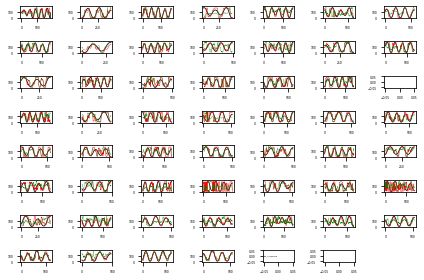

Participant:  1  /  4


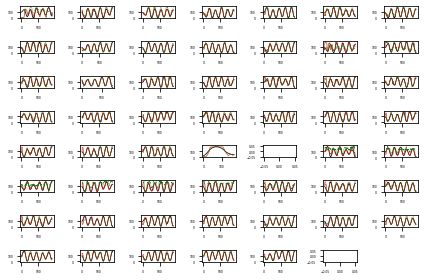

Participant:  2  /  4


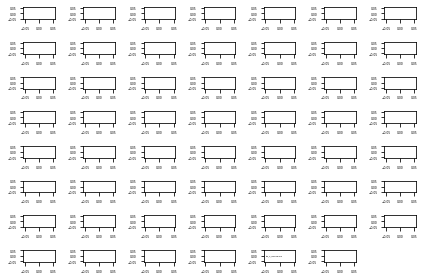

Participant:  3  /  4


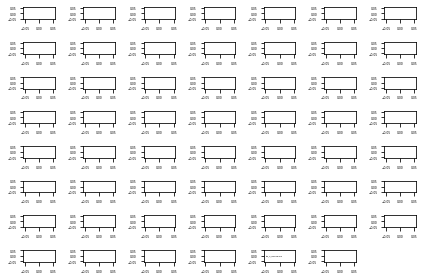

In [132]:
# For each participant show all the trials, with target, raw and reconstructed dial angles
# fig, axs = plt.subplots(8,7)

plt.figure(1)

participants = pd.unique(df_all['PtxID'])
trials = pd.unique(df_all['trial'])

for ptx, pt in enumerate(participants):
    print('Participant: ', ptx, ' / ', len(participants))
    for tr in trials:

        mask = (df_all['PtxID'] == pt) &  (df_all['group'] == 'Reward') &  (df_all['trial'] == tr)
        dial = df_all[mask]['Dial_Raw'].values
        dialRecon = df_all[mask]['Dial_Recon'].values
        target = df_all[mask]['Target'].values

        # Extract group automatically 
        gmask = (df_all['PtxID'] == pt)
        grp = df_all[gmask]['group']
        group = grp.values[0]

        plt.subplot(8,7,tr+1)
        plt.plot(target,'k',linewidth = 0.75)
        plt.plot(dial,'r',linewidth = 0.45)
        plt.plot(dialRecon,'g',linewidth = 0.25)
        plt.xticks(fontsize = 3)
        plt.yticks(fontsize = 3)
        plt.tight_layout()

    plt.subplot(8,7,tr+1)
    plt.plot(0,0,'k')
    plt.plot(0,0,'r')
    plt.plot(0,0,'g')
    plt.legend(['Target','Raw Dial','Recon Dial'])
    plt.text(-0.05,0, 'ptx_' + str(ptx) + '_' + group ,fontsize=2)
    plt.savefig(path + "/Figures/" + 'ptx_' + str(ptx) + '_' + str(np.round(time.time())) + "Dial_Reconstruction.png", dpi = 1200)
    plt.show()
    
    # plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper right')
    # plt.legend(['Target','Dial','Dial_Reconst.'])
    # plt.tight_layout()
    # plt.xlabel('Samples')
    # plt.ylabel('Angle (degree)')

#### New curve fitting reconstruction method using the original raw dial data as input

In [142]:
import numpy as np
from scipy.optimize import leastsq
import pylab as plt

##### Extract example trial data from one of the participatns

In [300]:
df_all.head(2)

,PtxID,trial,group,hand,age,sex,Dial_Raw,Dial_Recon,Target,Score,...,VxPos,VyPos,VzPos,Vrot,Frame,Joint,xPos,yPos,zPos,rot
0,bK933906299Id748,0,Reward,R,12,M,89.839,81.241489,96.072,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bK933906299Id748,0,Reward,R,12,M,92.359,81.241489,96.072,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(0.0, 180.0)

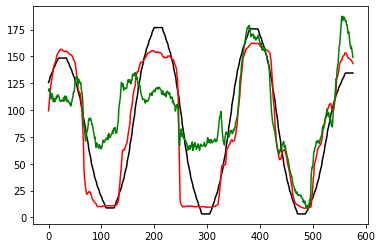

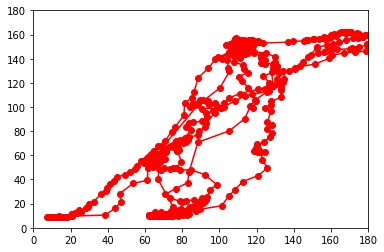

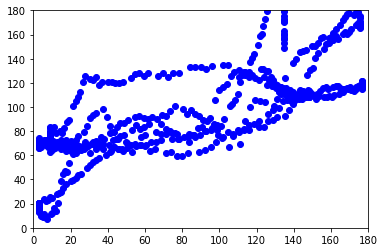

In [440]:
mask = (df_all['PtxID'] == 'bK933906299Id748') &  (df_all['group'] == 'Reward') &  (df_all['trial'] == 6)
dial_raw0 = df_all[mask]['Dial_Raw'].values
dial_raw = dial_raw0[~numpy.isnan(dial_raw0)]

targ = df_all[mask]['Target'].values
target = targ[~numpy.isnan(targ)]

dial = df_all[mask]['Dial_Recon'].values
dial2 = dial[~numpy.isnan(dial)]

plt.figure()
plt.plot(target, 'k')
plt.plot(dial_raw, 'r')
plt.plot(dial2, 'g')
# plt.axis('equal')

plt.figure()
plt.plot(dial2, dial_raw, 'r-o')
# plt.axis('equal')
plt.xlim([0, 180])
plt.ylim([0, 180])

plt.figure()
plt.plot(target, dial2,'bo')
plt.xlim([0, 180])
plt.ylim([0, 180])

##### Method 1 (doesn't work so well, i.e. many data points are ignored)

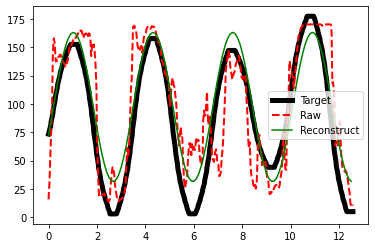

In [344]:
N = len(dial2) #1000 # number of data points
t = np.linspace(0, 4*np.pi, N)
f = 1.15247 # Optional!! Advised not to use
data = dial2 #3.0*np.sin(f*t+0.001) + 0.5 + np.random.randn(N) # create artificial data with noise

guess_mean = np.mean(data)
guess_std = 3*np.std(data)/(2**0.5)/(2**0.5)
guess_phase = 0.01
guess_freq = 2
guess_amp = 15

# Compute a first estimate. This might already be good enough, which I doubt 
data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean

# Define the function to optimize, in this case, to minimize the difference
# between the actual dial angle and the "guessed" parameters
optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - data
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

# Recreate the fitted curve using the optimized parameters
data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean

# Recreate the fitted curve using the optimized parameters
fine_t = np.arange(0,max(t),0.1)
data_fit = est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean

plt.plot(t, target, 'k-',linewidth=5)
plt.plot(t, data, 'r--',linewidth=2)
# plt.plot(t, data_first_guess, label='first guess')
plt.plot(fine_t, data_fit, label='Reconstrcuted',color='g')
plt.legend(['Target','Raw','Reconstruct'])
plt.show()

##### Method 2

In [444]:
from numpy import sin
from numpy import sqrt
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot

In [445]:
# Fit a line to the raw dial angle data

# define the true objective function
def objective1(x, a, b, c, d):
	return a * sin(b - x) + c * x**2 + d

def objective2(x, a, b, c, d, e, f):
	return (a * x) + (b * x**2) + (c * x**3) + (d * x**4) + (e * x**5) + f

def objective3(x, a, p, v, f):
    # x = input data 
    # a = amplitude
    # f = frequency aka period (2*pi/f)
    # p = phase shift
    # v = vertical shift 
    return a * sin((f * x) + p) + v

def FitCurve(y, target, func = 1):
    
    # the dataset
    N = len(y)
    x = np.linspace(0, 4*np.pi, N)
    
    # define a sequence of inputs between the smallest and largest known inputs
    x_line = arange(min(x), max(x), 1)
    
    # summarize the parameter values
    if func == 1:
        popt, _ = curve_fit(objective1, x, y) # curve fit
        a, b, c, d = popt # objective1  
        y_line = objective1(x_line, a, b, c, d) # calculate the output for the range
    elif func == 2:
        popt, _ = curve_fit(objective2, x, y) # curve fit
        a, b, c, d, e, f = popt # objective2
        y_line = objective2(x_line, a, b, c, d, e, f) # calculate the output for the range
    elif func == 3:
        popt, _ = curve_fit(objective3, x, y) # curve fit
        a, b, c, f = popt # objective3
        y_line = objective3(x_line, a, b, c, f) # calculate the output for the range
    
    print(popt)

    # create a line plot for the mapping function
    # plot input vs output
    pyplot.scatter(x, target, color='k',linewidth=5)
    pyplot.plot(x, y,'r--',linewidth=3)
    pyplot.plot(x_line, y_line, '-', color='green', linewidth=2)
    pyplot.show()

[11.63709023  8.62151389 99.96676827  3.23000724]


ValueError: x and y must be the same size

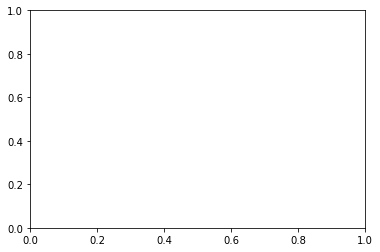

In [446]:
FitCurve(y, target, 3)

# Old Code

In [195]:
# # Show example plot of raw dial data
# print('Size of t: ', np.shape(t))
# print('Size of dial: ', np.shape(dial))

# # dial = dial
# # dial2 = ResizeArray(dial, 1000)
# # dial2 = [(i * np.nan) for i in dial if i == np.nan]
# dial2 = dial[~numpy.isnan(dial)]
# print('Size of dial after resize: ', np.shape(dial2))

# plt.plot(t)
# plt.plot(dial,'r-o')
# plt.plot(dial2,'g-o')

In [63]:
# # Test to read more data
# # path = "H:/Project/SubEscape/SubEscape_Data_Analysis/Data_Subset/"

# folders = os.listdir(path)
# folderNames = unique(folders)
# # df = None 
# # df_all = None

# folderIndex = 160 # Put this into a for loop to go through all the files for the dial 
# f = folderNames[folderIndex]

# folderWords = str.split(f,'_')

# ptxIDs = folderWords[1]
# age = folderWords[2]
# sex = folderWords[3]
# hand = folderWords[4]
# group = folderWords[5]
# trial = folderWords[9]

# tmpDF = pd.read_json(path + f, orient='index')

# # Extract pose data from each of the metrics 
# dial = []
# target = []
# score = []

# # tmpDF.loc['dialData'].values[0][i]
# for i in tmpDF.loc['dialData'].values[0]: 
#     metricParts = str.split(i,';')
#     dial.append(float(metricParts[0]))
#     target.append(float(metricParts[1]))
#     score.append(float(metricParts[2]))

# data = {'Dial' : dial,
#        'Target' : target,
#        'Score' : score,}

# tmpDF2 = pd.DataFrame(data)
# tmpDF2.insert(0,'PtxID',ptxIDs)
# tmpDF2.insert(1,'trial',trial)
# tmpDF2.insert(2,'group',group)
# tmpDF2.insert(3,'hand',hand)
# tmpDF2.insert(4,'age',age)
# tmpDF2.insert(5,'sex',sex)

# tmpDF2

In [5]:
# def ReadFiles(path, files):
#     # Define data frame variable
#     df = None 
#     startTime = time.time()
  
#     print('Number of files: ', len(files))
    
#     # Load each file into the data frame 
#     for i in range(len(files)): 
    
#         if ".json" in files[i] and "Phase" in files[i] and "QNumber" not in files[i]:    
#         # if "txt.json" in files[i] and "Phase" in files[i]:
#               # print(files[i])

#             # elapsedTime = time.time() - startTime
#             # print('Time passed: ', np.round(elapsedTime), '\t sec \r')

#             # Extract file name info and add to the dataframe 
#             fileWords = files[i].split("_")

#             # Extract phase 
#             idx = fileWords.index("Phase")
#             phase = fileWords[idx + 1]

#             # Extract user ID 
#             idx = fileWords.index("trial")
#             userID = fileWords[idx - 1]

#             # Add trial number to data frame 
#             try:
# #                 print('Path and File: ', [path + '/' + files[i]])
#                 tmpDF = pd.read_json(path + '/' + files[i])
#                 tmpDF.insert(0, "Phase", phase, True)
#                 tmpDF.insert(0, "UserID", userID, True)

#                 if df is None:
#                     df = tmpDF
#                 else:
#                     df = pd.concat((df, tmpDF))
#             except Exception as e:
#                 print('My_Err: ', e)
#     return df

In [ ]:
# frame = { 'headPose': dfs.loc['headPose'].values[0], 
#          'handPose': dfs.loc['headPose'].values[0],
#         'fingData': dfs.loc['fingData'].values[0],
#         'vfingData': dfs.loc['vfingData'].values[0],
#         'dialData': dfs.loc['dialData'].values[0],
#         'trialTime': dfs.loc['trialTime'].values[0],}
  
# df_all = pd.DataFrame(frame)

# df_all

In [34]:
# # Extract pose data from each of the metrics 
# frame = []
# joint = []
# xPos = []
# yPos = []
# zPos = []
# rot = []
# for i in np.arange(len(dfs.loc['fingData'].values[0])):
#     metricParts = str.split(dfs.loc['fingData'].values[0][i],';')
#     frame.append(metricParts[0])
#     joint.append(metricParts[1])
#     xPos.append(metricParts[2])
#     yPos.append(metricParts[3])
#     zPos.append(metricParts[4])
#     rot.append(metricParts[5])

# data = {'Fame' : frame,
#        'Joint' : joint,
#        'xPos' : xPos,
#        'yPos' : yPos,
#        'zPos' : zPos,
#        'rot' : rot,}

# df_allTest = pd.DataFrame(data)

# df_allTest

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# f =open("1610062712_Qm559862102iI716_44_M_R__NoReward_1018_165_4.txt")

# # convert the file object to a list so one can work on it 
# mylist = [line.rstrip('\n') for line in f] 

# # convert the list to a long string 
# d = str()
# for i in range(len(mylist)):
#     d += mylist[i]
    
# numVars = 8
# # Separate the string into the different variables (;)
# variables = d.split(";")


# # This part is for loading the fingers
# numFingers = 16
# frameRate = 60.24096
# trialDuration = 15
# numAxis = 4
# fingerNames = ['tmb1','tmb2','tmb3',
#                'idx1','idx2','idx3',
#                'mid1','mid2','mid3',
#                'rng1','rng2','rng3',
#                'pnk1','pnk2','pnk3', 'wrist']

# allFingDF = None 
# allData = None 

# fingerPoses = variables[3].split(":") # Separate the different frames (:)

# # Loopify this part later on to go through all the frames and fingers ...
# for fx in range(len(fingerPoses)):
    
#     if len(fingerPoses[fx]) > 470:
        
#         indifings = fingerPoses[fx].split("|")
#         fings = str().join(indifings).split(",")

#         fingX = 0.0
#         fingY = 0.0
#         fingZ = 0.0
#         fingR = 0.0

#         j = 0
#         fc = 0
#         for i in range(len(fings)-1): # Go through each finger (16) and each axis (4) = 64 data points per frame 
            
#             if j == 0:
#                 fingX = float(fings[i+1])
#             elif j == 1:
#                 fingY = float(fings[i+1])
#             elif j == 2:
#                 fingZ = float(fings[i+1])
#             elif j == 3:
#                 fingR = float(fings[i+1])
            
            
#             j = j+1
#             if j > 3:
#                 tmpResampled = [[fingX,fingY,fingZ,fingR]]
#                 tmpRes = pd.DataFrame(tmpResampled,columns=['Fx','Fy','Fz','Fr'])
#                 tmpRes.insert(0, "Participant_ID", variables[0] , True) # Add participant id to dataframe
#                 tmpRes.insert(0, "Trial", variables[2] , True) # Add trial number to dataframe
                
#                 try:
#                     fingerNameArr = fingerNames[fc]
#                     tmpRes.insert(0, "Digit", fingerNameArr, True) # Add digit name to dataframe
#                 except Exception as e: 
#                     print(e)
                    
#                 tmpRes.insert(0, "Frame", fx, True)
                
#                 if allFingDF is None: 
#                     allFingDF = tmpRes
#                 else:
#                     allFingDF = pd.concat((allFingDF, tmpRes))
                    
#                 j = 0
#                 fc = fc+1


# # Plot
# xval = np.arange(len(allFingDF[allFingDF["Digit"] == "tmb1"].Fx))
# trialTime = len(allFingDF[allFingDF["Digit"] == "tmb1"].Fx)/frameRate
# timeVals = np.linspace(0.0,trialTime,len(xval))

# plt.plot(timeVals,allFingDF[allFingDF["Digit"] == "idx1"].Fr,'r')
# plt.plot(timeVals,allFingDF[allFingDF["Digit"] == "idx2"].Fr,'g')
# plt.plot(timeVals,allFingDF[allFingDF["Digit"] == "idx3"].Fr,'b')
# plt.legend(['Dist','Midial','Prox'])

# plt.xlabel("Time / s")
# plt.ylabel("Joint Bend Angle / degrees")
# plt.title("Proximal Index Joint")
# plt.ylim([250.0, 360.0])



# # This part is for loading everything else
# allData = None 

# armPoses = variables[4].split(":") # Separate the different frames (:)
# headPoses = variables[5].split(":") # Separate the different frames (:)
# dialInfo = variables[6].split(":") # Separate the different frames (:)

# armX, armY, armZ, armRx, armRy, armRz = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
# headX, headY, headZ, headRx, headRy, headRz = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
# dialAngle, targetAngle, Score = 0.0, 0.0, 0.0

# # Loopify this part later on to go through all the frames and fingers ...
# for fx in range(len(armPoses)):
    
#     if len(armPoses[fx]) > 40:
        
#         # Other data start -------------------------
#         arms = str().join(armPoses[fx]).split(",")
#         heads = str().join(headPoses[fx]).split(",")
#         dial = str().join(dialInfo[fx]).split(",")
        
#         try:
#             armX = arms[1]
#             armY = arms[2]
#             armZ = arms[3]
#             armRx = arms[4]
#             armRy = arms[5]
#             armRz = arms[6]
            
#             headX = heads[1]
#             headY = heads[2]
#             headZ = heads[3]
#             headRx = heads[4]
#             headRy = heads[5]
#             headRz = heads[6]
            
#             dialAngle = dial[1]
#             targetAngle = dial[2]
#             Score = dial[3]
            
#             tmpAccumulated = [[armX,armY,armZ,armRx,armRy,armRz, 
#                                headX,headY,headZ,headRx,headRy,headRz,
#                                dialAngle,targetAngle,Score]]
#             tmpDats = pd.DataFrame(tmpAccumulated,columns=['armFx','armFy','armFz','armFRx','armFRy','armFRz',
#                                                            'headFx','headFy','headFz','headFRx','headFRy','headFRz',
#                                                            'DialAngle','TargetAngle','Score'])
            
#             tmpDats.insert(0, "Participant_ID", variables[0] , True) # Add participant id to dataframe
#             tmpDats.insert(0, "Trial", variables[2] , True) # Add trial number to dataframe
#             tmpDats.insert(0, "Frame", fx, True)

#             if allFingDF is None: 
#                 allData = tmpDats
#             else:
#                 allData = pd.concat((allData, tmpDats))
        
#         except Exception as e:
#             print("Something went wrong: ", e)
#         # Other data end -------------------------

# # Plot
# xval = np.arange(len(allData.headFx))
# trialTime = len(allData.headFx)/frameRate
# timeVals = np.linspace(0.0,trialTime,len(xval))

# plt.plot(timeVals,allData.DialAngle,'r')
# plt.plot(timeVals,allData.TargetAngle,'g')
# plt.plot(timeVals,allData.Score,'b')
# plt.legend(['Dial','Target','Score'])
# # plt.legend(['Dial','Target'])

# plt.xlabel("Time / s")
# plt.ylabel("Dial-Target / Degrees")
# plt.title("Performance")